# Decision Tree para prever o custo de um seguro saúde será alto ou baixo

## Importar livrarias

In [510]:
#Importar livrarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Dict, Any

In [511]:
#Importar Modelos
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBRFClassifier 
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

## Obtenção de data

In [ ]:
#ler dataset
df=pd.read_csv(r'...\dataset.csv')

#print às primeira 5 linhas
df.head()

,Unnamed: 0,age,sex,bmi,children,smoker,region,costs
0,0,19,female,27.900,0,yes,southwest,High
1,1,18,male,33.770,1,no,southeast,Low
2,2,28,male,33.000,3,no,southeast,Low
3,3,33,male,22.705,0,no,northwest,High
4,4,32,male,28.880,0,no,northwest,Low


In [513]:
#media, desvio, min, max, percetis e número de dados
df.describe()

,Unnamed: 0,age,bmi,children
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,668.500000,39.207025,30.663397,1.094918
std,386.391641,14.049960,6.098187,1.205493
min,0.000000,18.000000,15.960000,0.000000
25%,334.250000,27.000000,26.296250,0.000000
50%,668.500000,39.000000,30.400000,1.000000
75%,1002.750000,51.000000,34.693750,2.000000
max,1337.000000,64.000000,53.130000,5.000000


In [514]:
#nome das colunas
df.columns

Index(['Unnamed: 0', 'age', 'sex', 'bmi', 'children', 'smoker', 'region',
       'costs'],
      dtype='object')

In [515]:
#Eliminar a coluna unnamed, não contem valor nenhum para o estudo; na linha 1339 corresponde a  1337; na linha 2 corresponde a 0; parece apenas numeração.
df = df.drop(columns=["Unnamed: 0"])

In [516]:
#primeiras 5 linhas do datset
df.head()

,age,sex,bmi,children,smoker,region,costs
0,19,female,27.900,0,yes,southwest,High
1,18,male,33.770,1,no,southeast,Low
2,28,male,33.000,3,no,southeast,Low
3,33,male,22.705,0,no,northwest,High
4,32,male,28.880,0,no,northwest,Low


In [517]:
#descrição do dataset
df.describe()

,age,bmi,children
count,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918
std,14.049960,6.098187,1.205493
min,18.000000,15.960000,0.000000
25%,27.000000,26.296250,0.000000
50%,39.000000,30.400000,1.000000
75%,51.000000,34.693750,2.000000
max,64.000000,53.130000,5.000000


## Tratamento dos dados pré-tree

In [518]:
#informação em relação ao numero de dado não nulos e o tipo de dado
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   costs     1338 non-null   object 
dtypes: float64(1), int64(2), object(4)
memory usage: 73.3+ KB


#não existem nulos; mas teremos de mudar os objetos para binários -> sex, smoker, region; costs mantém objeto porque é para o estudo, mudamos à frente

In [519]:
#acionar enconder
encoder = OneHotEncoder(sparse_output=False)

In [520]:
#verificar colunas
df.columns

Index(['age', 'sex', 'bmi', 'children', 'smoker', 'region', 'costs'], dtype='object')

In [521]:
# Colunas a codificar
c=['sex', 'smoker', 'region']

# Encoding feito nas colunas c, mantendo toda a dataframe df - as outras colunas não são alteradas e mantêm-se
encoded_data = encoder.fit_transform(df[c])

#Verificar os elementos das colunas
encoder.categories_

[array(['female', 'male'], dtype=object),
 array(['no', 'yes'], dtype=object),
 array(['northeast', 'northwest', 'southeast', 'southwest'], dtype=object)]

In [522]:
#Verificar data encoded
encoded_data

array([[1., 0., 0., ..., 0., 0., 1.],
       [0., 1., 1., ..., 0., 1., 0.],
       [0., 1., 1., ..., 0., 1., 0.],
       ...,
       [1., 0., 1., ..., 0., 1., 0.],
       [1., 0., 1., ..., 0., 0., 1.],
       [1., 0., 0., ..., 1., 0., 0.]])

In [523]:
# Obtém os nomes das novas colunas
feature_names = encoder.get_feature_names_out(c)

In [524]:
#Verificar novas colunas
feature_names

array(['sex_female', 'sex_male', 'smoker_no', 'smoker_yes',
       'region_northeast', 'region_northwest', 'region_southeast',
       'region_southwest'], dtype=object)

In [525]:
# Criar a DataFrame com a data encoded
encoded_df = pd.DataFrame(encoded_data, columns=feature_names)
encoded_df

,sex_female,sex_male,smoker_no,smoker_yes,region_northeast,region_northwest,region_southeast,region_southwest
0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
1,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0
2,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0
3,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0
4,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...
1333,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0
1334,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
1335,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1336,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0


In [526]:
#Resetar o indice para não haver erros mais à frente
df = df.reset_index(drop=True)
encoded_df = encoded_df.reset_index(drop=True)

In [527]:
# Combinar o dataframe encoded com o original(optional)
df2 = pd.concat([df, encoded_df], axis=1)
df=df2.drop(c,axis=1)

In [528]:
#Verificar o dataset processado para iniciar os testes
df

,age,bmi,children,costs,sex_female,sex_male,smoker_no,smoker_yes,region_northeast,region_northwest,region_southeast,region_southwest
0,19,27.900,0,High,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
1,18,33.770,1,Low,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0
2,28,33.000,3,Low,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0
3,33,22.705,0,High,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0
4,32,28.880,0,Low,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
1333,50,30.970,3,High,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0
1334,18,31.920,0,Low,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
1335,18,36.850,0,Low,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1336,21,25.800,0,Low,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0


## Split

In [529]:
#shuffle ao dataframe
df1 = df.sample(frac=1)

In [530]:
#Transformar target em binário e separar features e target
y = df1['costs'].map({'Low':0, 'High':1})
X = df1.drop(columns='costs')

#usar train_test_plit para separar aleatoriamente os dados para treino e teste

In [531]:
#Divisão treino/teste (80/20) com estratificação
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

## Treino

## Decision tree

In [532]:
#Usar decision tree
clf = DecisionTreeClassifier()

In [533]:
#Treina modelo
clf.fit(X_train, y_train)

DecisionTreeClassifier()

In [534]:
#Gera as previsões
y_predict = clf.predict(X_test)

In [535]:
#Teste de accuracy das previsões
accuracy_score(y_test, y_predict)

0.9029850746268657

##Bons valores de accuracy

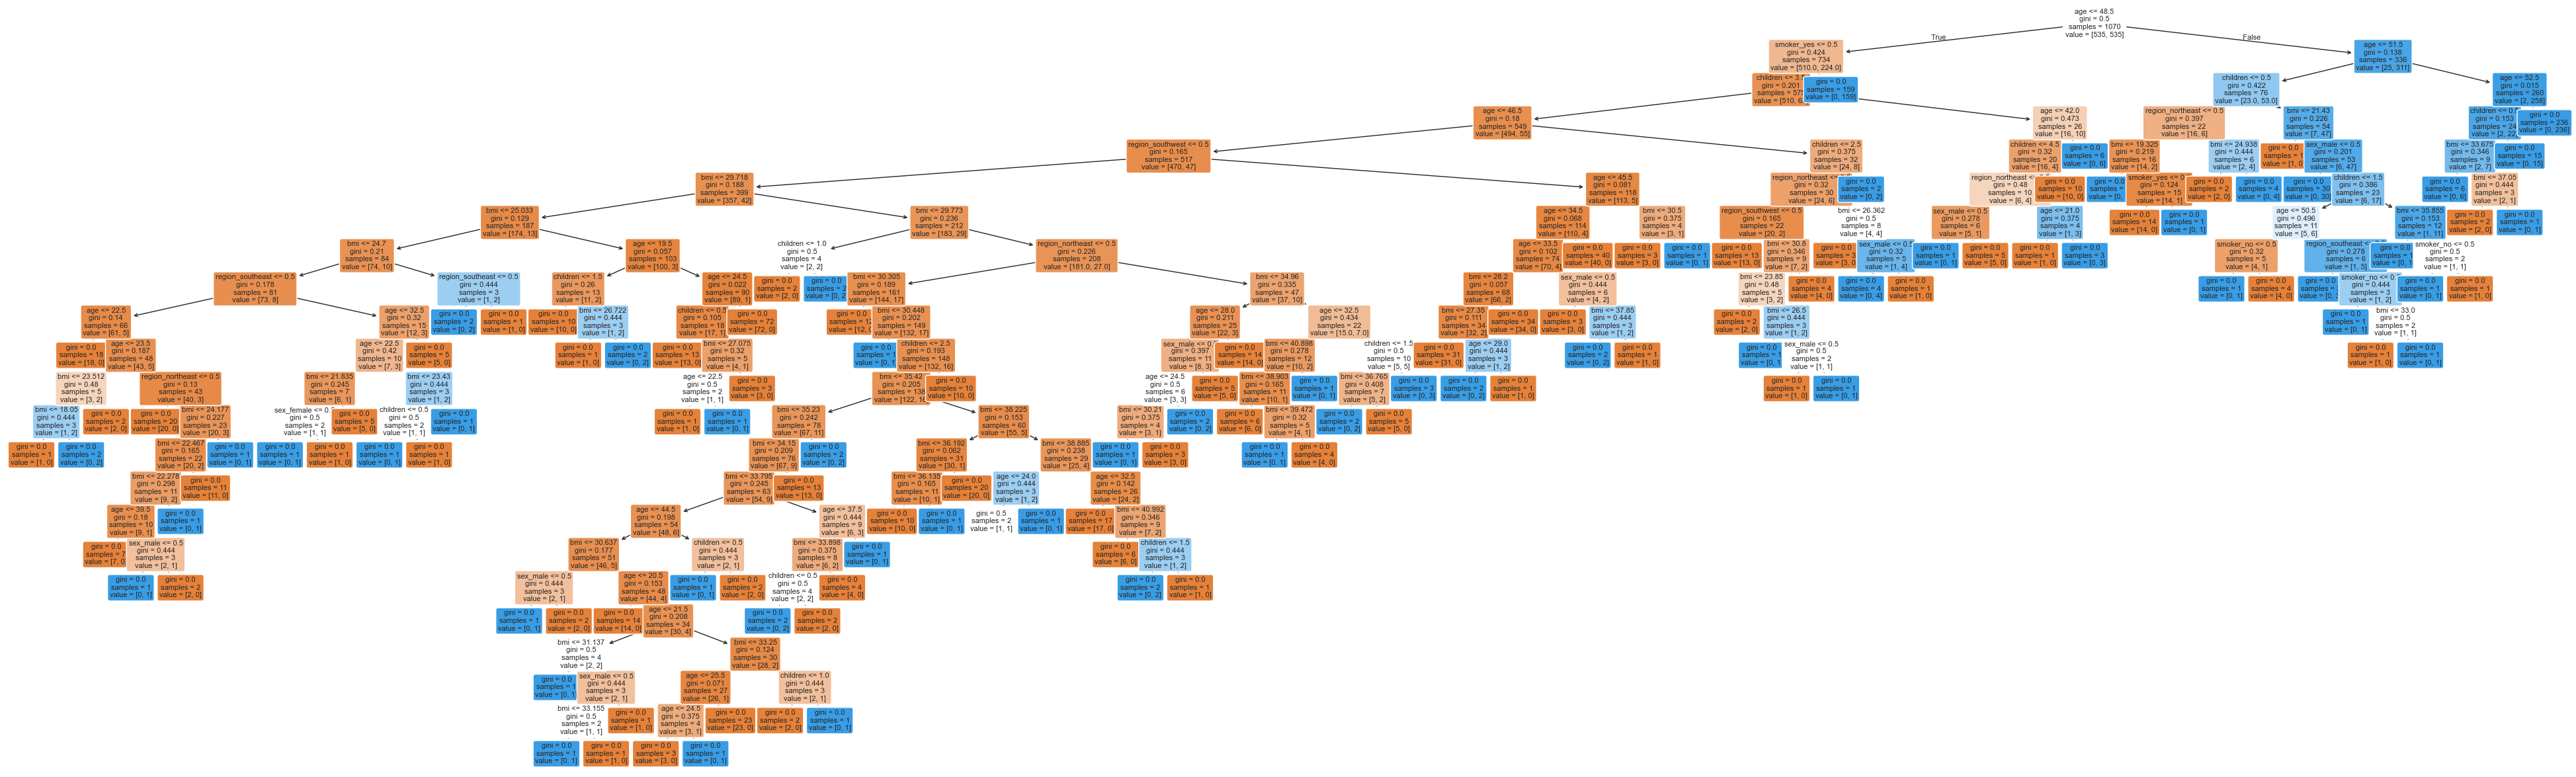

In [536]:
#Visualizar tree
plt.figure(figsize=(50,15))
plot_tree(clf, filled=True, rounded=True, fontsize=8, feature_names=X_train.columns)
plt.show()

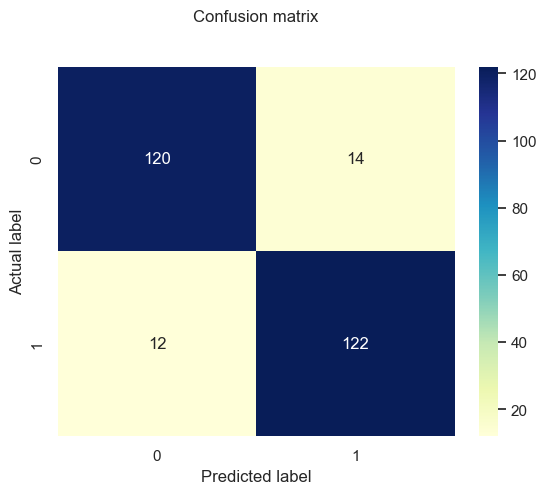

In [537]:
#avaliar a performance dos classificadores; mostra quantas previsões o modelo acertou e errou
# TN = True Negative (00) FP = False Positive(01) FN = False Negative(10), TP = True Positive(11)
cnf_matrix = confusion_matrix(y_test, y_predict)
p = sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

## Random Forest

In [538]:
#Modelo random forest
rf = RandomForestClassifier(random_state=42)
#Inicia treino
rf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [539]:
#Gera previsões dos dados
rf_pred = rf.predict(X_test)

#Print da accuracy
print('Random Forest Accuracy:', accuracy_score(y_test, rf_pred))

Random Forest Accuracy: 0.9402985074626866


###accuracy incrivel!!

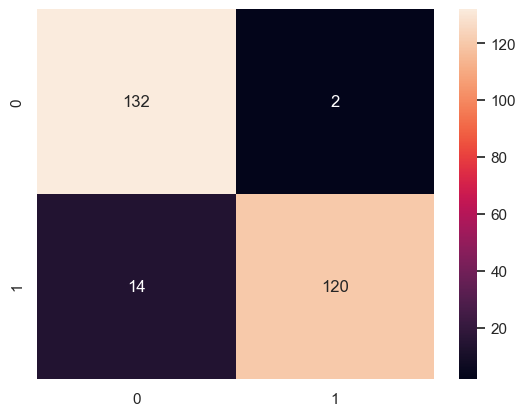

In [540]:
sns.heatmap(confusion_matrix(y_test, rf_pred), annot=True, fmt='g')
plt.show()

## Support Vector Machine (SVM)

In [541]:
#Modelo SVM
svm = SVC(random_state=42)
#Inicia Treino
svm.fit(X_train, y_train)

SVC(random_state=42)

In [542]:
#Gera previsão
svm_pred=svm.predict(X_test)
#Vê a accuracy
svm_acc=accuracy_score(y_test, svm_pred)
print(svm_acc)

0.7947761194029851


##muito boa accuracy

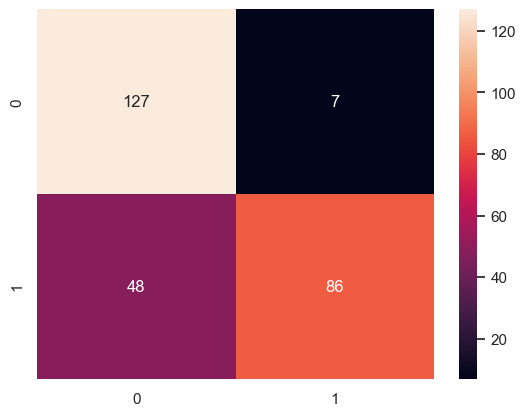

In [543]:
#Plot da accuracy
sns.heatmap(confusion_matrix(y_test, svm_pred), annot=True, fmt='g')
plt.show()

## XGBoost

In [544]:
#Inicia modelo XGBoost
xgb = XGBRFClassifier(random_state=42)
#Inicia treino
xgb.fit(X_train, y_train)

XGBRFClassifier(base_score=None, booster=None, callbacks=None,
                colsample_bylevel=None, colsample_bytree=None, device=None,
                early_stopping_rounds=None, enable_categorical=False,
                eval_metric=None, feature_types=None, feature_weights=None,
                gamma=None, grow_policy=None, importance_type=None,
                interaction_constraints=None, max_bin=None,
                max_cat_threshold=None, max_cat_to_onehot=None,
                max_delta_step=None, max_depth=None, max_leaves=None,
                min_child_weight=None, missing=nan, monotone_constraints=None,
                multi_strategy=None, n_estimators=None, n_jobs=None,
                num_parallel_tree=None, objective='binary:logistic',
                random_state=42, ...)

In [545]:
xgb_pred = xgb.predict(X_test)
xgb_acc = accuracy_score(y_test, xgb_pred)
print(xgb_acc)

0.9440298507462687


##otimos valores accuracy

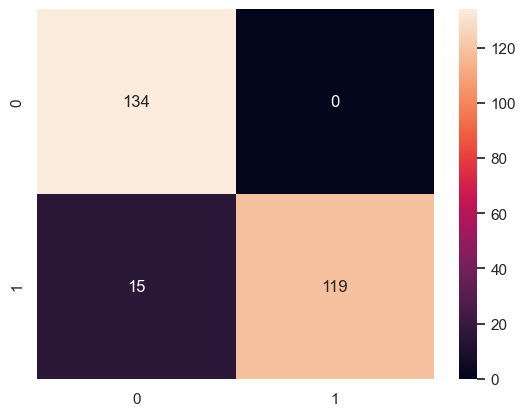

In [546]:
sns.heatmap(confusion_matrix(y_test, xgb_pred), annot=True, fmt='g')
plt.show()

## Avaliação dos modelos

In [547]:
# Avaliar Decision Tree
res_dt = evaluate_model(clf, "Decision Tree", "Baseline", X_test, y_test)
resultados = pd.concat([resultados, res_dt], ignore_index=True)

# Avaliar Random Forest
res_rf = evaluate_model(rf, "Random Forest", "Baseline", X_test, y_test)
resultados = pd.concat([resultados, res_rf], ignore_index=True)

# Avaliar SVM
res_svm = evaluate_model(svm, "SVM", "Baseline", X_test, y_test)
resultados = pd.concat([resultados, res_svm], ignore_index=True)

# Avaliar XGBoost
res_xgb = evaluate_model(xgb, "XGBoost", "Baseline", X_test, y_test)
resultados = pd.concat([resultados, res_xgb], ignore_index=True)

# Mostrar resultados
print(resultados)

          Modelo      Tipo  Accuracy  Precision    Recall  F1-Score
0  Decision Tree  Baseline  0.891791   0.906977  0.873134  0.889734
1  Random Forest  Baseline  0.932836   0.975410  0.888060  0.929688
2            SVM  Baseline  0.802239   0.864865  0.716418  0.783673
3        XGBoost  Baseline  0.932836   0.975410  0.888060  0.929688
4  Decision Tree  Baseline  0.902985   0.897059  0.910448  0.903704
5  Random Forest  Baseline  0.940299   0.983607  0.895522  0.937500
6            SVM  Baseline  0.794776   0.924731  0.641791  0.757709
7        XGBoost  Baseline  0.944030   1.000000  0.888060  0.940711


## Otimização (GridSearchCV)

In [548]:
# Definir as grelhas de parâmetros
# Incluindo os valores 'default' (ou iniciais) na grelha.

# Decision Tree:
# Defaults: criterion='gini', max_depth=None, min_samples_leaf=1
param_grid_dt = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 5, 10, 15],
    'min_samples_leaf': [1, 2, 5, 10]
}

# Random Forest:
# Defaults: n_estimators=100, max_depth=None, min_samples_leaf=1
param_grid_rf = {
    'n_estimators': [50, 100, 200], # 100 é o default
    'max_depth': [None, 10, 20],
    'min_samples_leaf': [1, 2, 5]
}

# SVM:
# Defaults: C=1.0, kernel='rbf', gamma='scale'
param_grid_svm = {
    'C': [0.1, 1, 10], # 1 é o default
    'kernel': ['linear', 'rbf'], # 'rbf' é o default
    'gamma': ['scale', 'auto', 0.01] # 'scale' é o default
}

# XGBoost:
# Defaults: n_estimators=100, learning_rate=0.3, max_depth=6
param_grid_xgb = {
    'n_estimators': [100, 200], # 100 é o default
    'learning_rate': [0.1, 0.3], # 0.3 é o default
    'max_depth': [3, 6, 9] # 6 é o default
}

In [549]:
# Dicionário para guardar os melhores modelos
best_models: Dict[str, Any] = {}

In [550]:
def gscv(name,model,params):
    print(f"\nA otimizar {name}...")
    grid_search = GridSearchCV(estimator=model,
                             param_grid=params,
                             cv=5, # 5-fold cross-validation
                             scoring='f1', # Otimizar para F1-Score
                             n_jobs=-1, # Usar todos os processadores
                             verbose=0)
    
    grid_search.fit(X_train, y_train)
    best_models[name] = grid_search.best_estimator_
    print(f"Melhores parâmetros para {name}: {grid_search.best_params_}")   

In [551]:
#Otimizar
gscv("DT",DecisionTreeClassifier(random_state=24), param_grid_dt)
gscv("RF",RandomForestClassifier(random_state=24), param_grid_rf)
gscv("SVM",SVC(random_state=24), param_grid_svm)
gscv("XGBoost",XGBRFClassifier(random_state=24), param_grid_xgb)


A otimizar DT...
Melhores parâmetros para DT: {'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 10}

A otimizar RF...
Melhores parâmetros para RF: {'max_depth': 10, 'min_samples_leaf': 1, 'n_estimators': 200}

A otimizar SVM...
Melhores parâmetros para SVM: {'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}

A otimizar XGBoost...
Melhores parâmetros para XGBoost: {'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 100}


In [552]:
best_models

{'DT': DecisionTreeClassifier(min_samples_leaf=10, random_state=24),
 'RF': RandomForestClassifier(max_depth=10, n_estimators=200, random_state=24),
 'SVM': SVC(C=10, gamma=0.01, random_state=24),
 'XGBoost': XGBRFClassifier(base_score=None, booster=None, callbacks=None,
                 colsample_bylevel=None, colsample_bytree=None, device=None,
                 early_stopping_rounds=None, enable_categorical=False,
                 eval_metric=None, feature_types=None, feature_weights=None,
                 gamma=None, grow_policy=None, importance_type=None,
                 interaction_constraints=None, learning_rate=0.1, max_bin=None,
                 max_cat_threshold=None, max_cat_to_onehot=None,
                 max_delta_step=None, max_depth=6, max_leaves=None,
                 min_child_weight=None, missing=nan, monotone_constraints=None,
                 multi_strategy=None, n_estimators=100, n_jobs=None,
                 num_parallel_tree=None, objective='binary:logistic', ..

## Avaliação dos modelos

In [556]:
for name, model in best_models.items():
    print(f"A avaliar {name} (Otimizado)...")
    res=evaluate_model(model, name, 'Otimizado', X_test, y_test)
    resultados = pd.concat([resultados,res], ignore_index=True)

A avaliar DT (Otimizado)...
A avaliar RF (Otimizado)...
A avaliar SVM (Otimizado)...
A avaliar XGBoost (Otimizado)...


## Resultados finais

In [554]:
# Ordenar os resultados para melhor visualização
resultados_finais = resultados.sort_values(by=['Modelo', 'Tipo'], ascending=[True, True]).reset_index(drop=True)

print(resultados_finais)

           Modelo       Tipo  Accuracy  Precision    Recall  F1-Score
0              DT  Otimizado  0.914179   0.966387  0.858209  0.909091
1   Decision Tree   Baseline  0.891791   0.906977  0.873134  0.889734
2   Decision Tree   Baseline  0.902985   0.897059  0.910448  0.903704
3              RF  Otimizado  0.947761   1.000000  0.895522  0.944882
4   Random Forest   Baseline  0.932836   0.975410  0.888060  0.929688
5   Random Forest   Baseline  0.940299   0.983607  0.895522  0.937500
6             SVM   Baseline  0.802239   0.864865  0.716418  0.783673
7             SVM   Baseline  0.794776   0.924731  0.641791  0.757709
8             SVM  Otimizado  0.947761   1.000000  0.895522  0.944882
9         XGBoost   Baseline  0.932836   0.975410  0.888060  0.929688
10        XGBoost   Baseline  0.944030   1.000000  0.888060  0.940711
11        XGBoost  Otimizado  0.944030   1.000000  0.888060  0.940711



Gerando gráfico de comparação de F1-Score...


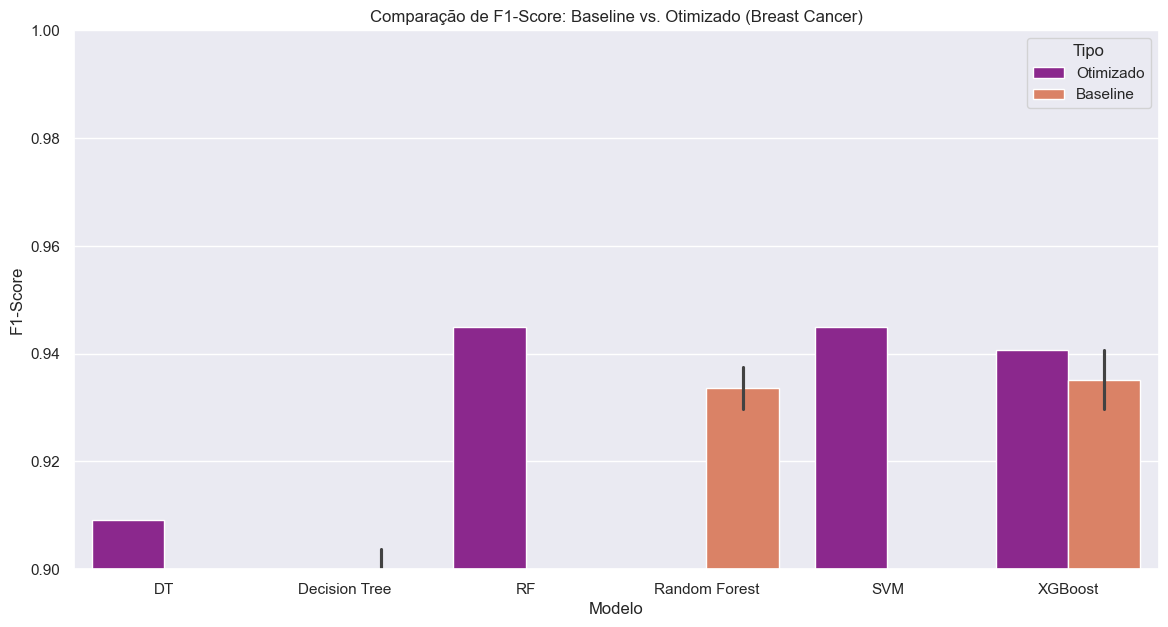

In [555]:
# Comparação gráfica
print("\nGerando gráfico de comparação de F1-Score...")

plt.figure(figsize=(14, 7))
sns.barplot(data=resultados_finais, x='Modelo', y='F1-Score', hue='Tipo', palette='plasma')
plt.title('Comparação de F1-Score: Baseline vs. Otimizado (Breast Cancer)')
plt.ylabel('F1-Score')
plt.xlabel('Modelo')
plt.legend(title='Tipo')
plt.ylim(0.9, 1.0) # Ajustar o zoom para ver melhor as diferenças
plt.show()